<a href="https://colab.research.google.com/github/glasry/DLcourse2/blob/main/SineWaveClippingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader

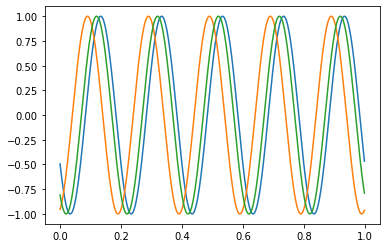

In [2]:
# Generate data
Ndata = 100 # size of data set
f0 = 5
fs = 1000
T  = 1
Nsamples = T * fs
tVec = np.arange(0, T, 1/fs).reshape(1, Nsamples)
y = np.empty((Ndata, Nsamples)) # initialize 2-D numpy array
vRandomPhase = np.random.uniform(-np.pi, np.pi, Ndata).reshape(Ndata, 1)
y = np.sin(2 * np.pi * f0 * tVec + vRandomPhase)
plt.figure()
plt.plot(np.transpose(tVec),y[0,:])
plt.plot(np.transpose(tVec),y[1,:])
plt.plot(np.transpose(tVec),y[2,:])
plt.show()

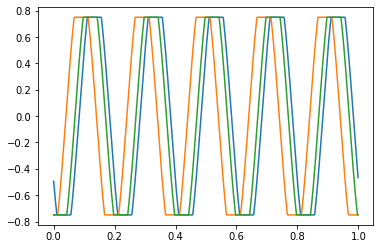

In [3]:
# get input and labels
X = y.copy()
X[X > 0.75] = 0.75
X[X<-0.75] = -0.75
plt.figure()
plt.plot(np.transpose(tVec),X[0,:])
plt.plot(np.transpose(tVec),X[1,:])
plt.plot(np.transpose(tVec),X[2,:])
plt.show()

In [4]:
# Prepare train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(y_test)

print('The training sizes are X,Y ', X_train.shape, Y_train.shape)
print('The test sizes of X,Y are', X_test.shape, Y_test.shape)

The training sizes are X,Y  torch.Size([80, 1000]) torch.Size([80, 1000])
The test sizes of X,Y are torch.Size([20, 1000]) torch.Size([20, 1000])


In [74]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, X):
        Activation = nn.Tanh()
        outputs, n_samples = [], X.size(0) # n_samples is the size of the batch
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in X.split(1, dim=1): # dim=1 is the time dimension
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            output = Activation(output)
            outputs.append(output)   
        outputs = torch.cat(outputs, dim=1)
        return outputs

class BLSTM(nn.Module):
    def __init__(self, hidden_size=64, num_layers=2):
        super(BLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=num_layers, bidirectional=True)
        self.linear = nn.Linear(2*self.hidden_size, 1)
        self.activation = nn.Tanh()
        
    def forward(self, X):
        # The input to the lstm is a (n_samples x batch_size x input_size) tensor
        n_samples, batch_size = X.shape[0], X.shape[1]
        h0 = torch.zeros(2*self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(2*self.num_layers, batch_size, self.hidden_size)
        out, hidden = self.lstm1(X, (h0, c0))
        out = self.linear(out)
        out = self.activation(out)
        out = torch.squeeze(out)
        out = torch.transpose(out, 1, 0)
        return out

In [15]:
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
print(inputs.shape)

torch.Size([5, 1, 3])


In [68]:
def training_loop(model, X_train, Y_train, X_validation, Y_validation, n_epochs, batch_size):
  
  # Define optimizer and loss function
  loss_fn = nn.MSELoss()
  optimiser = torch.optim.LBFGS(model.parameters(), lr=0.08)
  train_loss, val_loss = [], []
  # Adapt validation data for nn
  X_validation = X_validation[:,:,None]  
  X_validation = torch.transpose(X_validation, 0, 1)
  # Adapt training data for nn
  X_train = X_train[:,:,None]  
  X_train = torch.transpose(X_train, 0, 1)
  for iEpoch in range(n_epochs):
    # Shuffle the data
    idcs_shuffled = torch.randperm(X_train.shape[1])
    X_train_shuffle = X_train[:,idcs_shuffled,:]
    Y_train_shuffle = Y_train[idcs_shuffled,:]
    idx = 0
    while (idx+batch_size) <  X_train_shuffle.shape[1]:
      print("Epoch: {}, {}%".format(iEpoch, idx/X_train.shape[1]*100))
      X = X_train_shuffle[:,idx:idx+batch_size,:] # batch_size x n_samples
      Y = Y_train_shuffle[idx:idx+batch_size,:]
      def closure():
        optimiser.zero_grad()
        out = model(X)
        # print('Finished epoch ' + str(i))
        loss = loss_fn(out, Y)
        loss.backward()
        return loss
    
      optimiser.step(closure)
      idx = idx + batch_size
    with torch.no_grad():      
      pred = model(X_validation)
      loss = loss_fn(pred, Y_validation)
      y = pred.detach().numpy()
    # draw figures
    val_loss.append(loss)
    plt.figure(figsize=(12,6))
    plt.title(f"Step {iEpoch+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(xi, yi, colour):
        plt.plot(xi, colour, linewidth=2.0)
        plt.plot(yi, colour+":", linewidth=2.0)
    draw(X_validation[:,0,0], y[0], 'r')
    draw(X_validation[:,1,0], y[1], 'b')
    draw(X_validation[:,2,0], y[2], 'g')
    plt.show()
    # plt.savefig("predict%d.png"%i, dpi=200)
    # plt.close()
    # print the loss
    out = model(X_train)
    loss_print = loss_fn(out, Y_train)
    train_loss.append(loss_print)
    print("Step: {}, Loss train: {}, Loss val: {}".format(iEpoch, loss_print, loss))
  return train_loss, val_loss

In [ ]:
model = BLSTM()
train_loss, val_loss = training_loop(model, X_train, Y_train, X_test, Y_test, n_epochs=20, batch_size=20)

In [3]:
plt.figure
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

NameError: ignored